<a href="https://colab.research.google.com/github/tkoyama010/Colaboratory/blob/master/demo_unit_disk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Poisson's Equation on Unit Disk](https://gitpitch.com/tkoyama010/OpenCAE-tkoyama010/PyConJP2019#/)

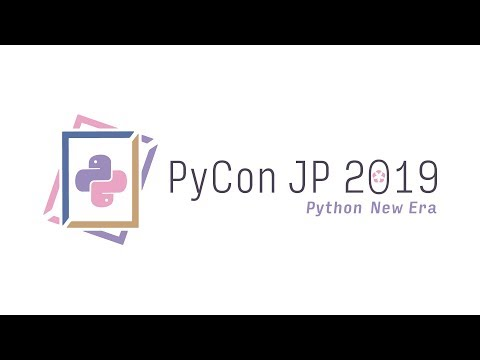

In [1]:
# @markdown This tutorial is a material of "Introduction to FEM Analysis with Python(Tetsuo Koyama)" in PyConJP2019.
from IPython.display import YouTubeVideo

YouTubeVideo("6JuB1GiDLQQ", width=600, height=400)


# Install
GetFEM++ packages are available in the official repositories of Debian and Ubuntu distributions. Plese use apt command to install from repository. For plotting the result, we can install meshio and matplotlib by pip command.

In [0]:
!apt install python-getfem++=5.2+dfsg1-6
!pip install meshio==2.3.10
!pip install matplotlib==2.2.4

#The problem setting
Let $\Omega \subset \mathbb{R}^2$ be the configuration of 2D circle (see the geomeroty [here](https://mathworks.com/help/pde/ug/solve-poissons-equation-on-a-unit-disk.html)). We will denoted by $u$ the state quantity. The equation of $u$ and boundary condition can be written as follows.

$-\Delta u = 1\ on\ \Omega$

$u = 0\ on\ d\Omega$

The exact solution of this problem is the following.

$u = \dfrac{1-x^2-y^2}{4}$

#Initialization

First import GetFEM++ and numpy. Also import matplotlib and meshio for plotting the results.

In [0]:
%matplotlib inline
import getfem as gf
import numpy as np
import matplotlib.pyplot as plt
import meshio


#Parameters of the model
Let us define the physical and numerical parameter of the problem.

In [0]:
# Approximate mesh length
h = 0.1
elements_degree = 2
center = [1.0, 1.0]
radius = 1.0
F = 1.0


#Mesh generation
We are going to use GetFEM++ meshing facility.
The geometory of the domain is supposed to be a circle. The geometory is described thanks to geometorical operation. In the following, h stands for the mesh size and 2 is the degree of the mesh (this means that the transformation is of degree two, we used curved edges).

In [0]:
mo = gf.MesherObject("ball", center, radius)
mesh = gf.Mesh("generate", mo, h, 2)


We can plot obtained mesh using matplotlib triplot. We use the Slice object to convert mesh to triangle form and export to vtk by using Slice object method. You can see the mesh of vtk using meshio and matplotlib.

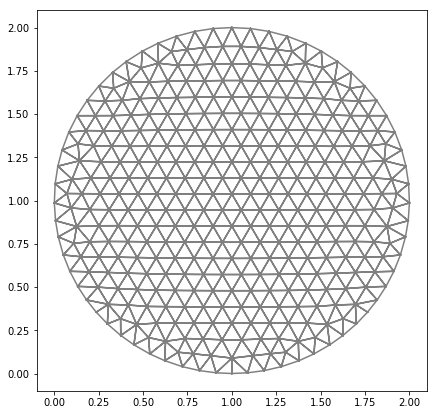

In [6]:
sl = gf.Slice(("none",), mesh, 1)
sl.export_to_vtk("sl.vtk", "ascii")

reader = meshio.read("sl.vtk")
x = reader.points
triangles = reader.cells["triangle"]

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.figure(figsize=(7, 7))
plt.triplot(x[:, 0], x[:, 1], triangles, color="gray")


To match the exact solution, we need to move the center of mesh in $(0, 0)$ position. We use the translate method to move the mesh.

In [0]:
mesh.translate([-1.0, -1.0])


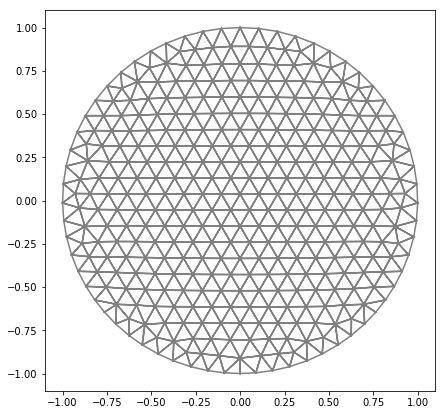

In [8]:
sl = gf.Slice(("none",), mesh, 1)
sl.export_to_vtk("sl.vtk", "ascii")

reader = meshio.read("sl.vtk")
x = reader.points
triangles = reader.cells["triangle"]

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.figure(figsize=(7, 7))
plt.triplot(x[:, 0], x[:, 1], triangles, color="gray")


#Boundary selection
We have to select the element faces on the mesh and define mesh region 1 to be the right boundary. This boundary number will be used in the model bricks.

In [0]:
fb = mesh.outer_faces()
OUTER_BOUND = 1
mesh.set_region(OUTER_BOUND, fb)


#Definition of finite element methods and integration method
We will define finite element method. *mfu* is to approximate the $u$.where the 1 stands for the dimension of the vector field. The second line sets the finite element used. *classical_finite_element* means a continuous Lagrange element and remember that elements_degree has been set to 2 which means that we will use quadratic (isoparametric) elements.

In [0]:
mfu = gf.MeshFem(mesh, 1)
mfu.set_classical_fem(elements_degree)


The last thing to define is an integration method *mim*. The order of the integration method have to be chosen sufficient to make a convenient integration of the selected finite element method. Here the square of *elements_degree* is sufficient.

In [0]:
mim = gf.MeshIm(mesh, pow(elements_degree, 2))


#Model definition
Let us declare a real model with the variable corresponding to $u$ to be computed.

In [0]:
md = gf.Model("real")
md.add_fem_variable("u", mfu)


#Laplacian problem
The following program take into account the Laplacian brick.

In [13]:
md.add_Laplacian_brick(mim, "u")


0

To add the RHS of equation, we use *add_source_term_brick* method. We can define constant variable by using *add_fem_data* and set variable using *set_variable*.

In [0]:
md.add_fem_data("F", mfu)
md.add_source_term_brick(mim, "u", "F")
md.set_variable("F", np.repeat(F, mfu.nbdof()))


We need to add Dirichlet condition at boundary of circle. In this example we use the following method.

In [15]:
md.add_Dirichlet_condition_with_multipliers(mim, "u", elements_degree - 1, OUTER_BOUND)


2

#Model solve
Once the model is correctly defined, we can simply solve it by the following program.

In [0]:
md.solve()
U = md.variable("u")


#Export/visualization of the solution
The finite element problem is solved. We can plot solution as follows.

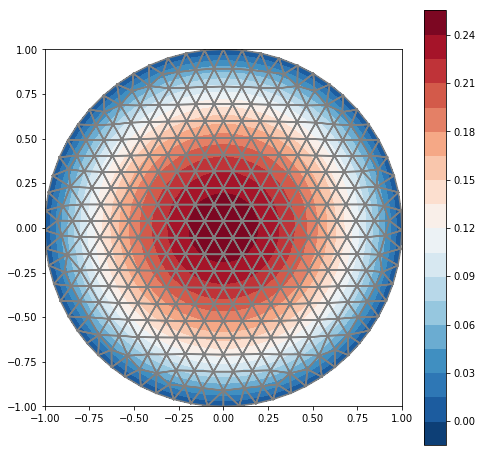

In [17]:
sl.export_to_vtk("u.vtk", "ascii", mfu, U, "U")
reader = meshio.read("u.vtk")
x = reader.points
triangles = reader.cells["triangle"]
point_data = reader.point_data["U"]

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.figure(figsize=(8, 8))
plt.triplot(x[:, 0], x[:, 1], triangles, color="gray")
contour = plt.tricontourf(x[:, 0], x[:, 1], triangles, point_data, 16, cmap="RdBu_r")
plt.colorbar(contour)
plt.gca().set_aspect("equal")


#Compare with exact solution

We can caluculate exact solution by using *eval* method.

In [0]:
xy = mfu.basic_dof_nodes()
x = xy[0, :]
y = xy[1, :]
sol = (1 - x * x - y * y) / 4.0


As you can see in plot. GetFEM++ result is correct.

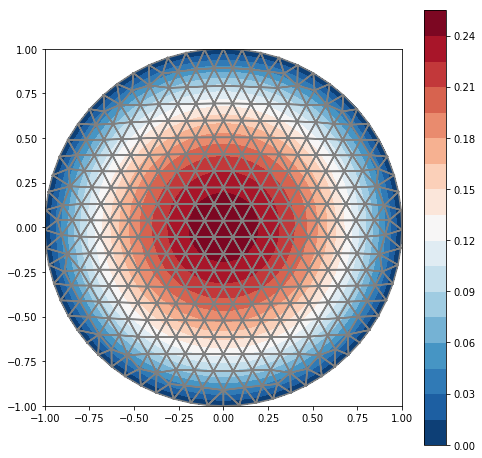

In [19]:
sl.export_to_vtk("sol.vtk", "ascii", mfu, sol, "solution")

reader = meshio.read("sol.vtk")
x = reader.points
triangles = reader.cells["triangle"]
point_data = reader.point_data["solution"]

plt.rcParams["figure.figsize"] = (10.0, 6.0)
plt.figure(figsize=(8, 8))
plt.triplot(x[:, 0], x[:, 1], triangles, color="gray")
contour = plt.tricontourf(x[:, 0], x[:, 1], triangles, point_data, 16, cmap="RdBu_r")
plt.colorbar(contour)
plt.gca().set_aspect("equal")
